In [1]:
%pip install opendp
%pip install 'opendp[polars]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.7/25.7 MB 8.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 93.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.8 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: polars━━━━━━━━━━━━━━━━━━ 0/2 [randomgen]
    Found existing installation: polars 1.29.00m 0/2 [randomgen]
    Uninstalling polars-1.29.0:━━━━━━━━━━━━━ 0/2 [randomgen]
      Successfully uninstalled polars-1.29.090m━━━━━━━━━━━━━━━━━━━ 1/2 [polars]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [polars]2m1/2 [polars]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import opendp.prelude as dp
import numpy as np
import polars as pl

dp.enable_features('contrib')

np.random.seed(42)

N = 1000
regions_fr = [
    "Île-de-France", "Auvergne-Rhône-Alpes", "Nouvelle-Aquitaine", "Occitanie",
    "Provence-Alpes-Côte d'Azur", "Grand Est", "Hauts-de-France", "Bretagne",
    "Normandie", "Centre-Val de Loire", "Pays de la Loire", "Bourgogne-Franche-Comté",
    "Corse"
]

DF_POLARS = pl.DataFrame({
    "sexe": np.random.choice(["H", "F"], size=N),
    "region": np.random.choice(regions_fr, size=N),
    "revenu_annuel": np.random.randint(10000, 80000, size=N),
    "profession": np.random.choice(["ingénieur", "médecin", "avocat"], size=N),
    "note_satisfaction": np.random.randint(0, 20, size=N) + 0.5 * np.random.randint(0, 2, size=N),
    "heures_travaillees": np.random.randint(20, 60, size=N),
    "secteur d'activité": np.random.choice(["public", "privé", "associatif"], size=N)
})

# Clés valides pour les filtres
KEY_VALUES = {
    "sexe": ["H", "F"],
    "region": regions_fr,
    "profession": ["ingénieur", "médecin", "avocat"],
    "secteur d'activité": ["public", "privé", "associatif"]
}

# Contexte DP, construit une seule fois
CONTEXT_PARAM = {
    "data": DF_POLARS.lazy(),
    "privacy_unit": dp.unit_of(contributions=2),
    "margins": [
        dp.polars.Margin(max_partition_length=1000),
        dp.polars.Margin(
            by=["region"],
            public_info="lengths"
        ),
        dp.polars.Margin(
            by=["secteur d'activité", "region", "sexe", "profession"],
            public_info="keys",
            max_partition_length=1000
        ),
    ],
}


In [3]:
expr = (
    dp.len()
)


expr = (
    pl.col("note_satisfaction")
    .fill_nan(0)
    .fill_null(0)
    .dp.sum(bounds=(10, 20))
)

expr = (
    pl.col("heures_travaillees")
    .fill_null(0)
    .dp.sum(bounds=(10, 20))
)


expr = (
    pl.col("heures_travaillees")
    .fill_null(0)
    .dp.mean(bounds=(10, 20))
)

expr = (
    pl.col("note_satisfaction")
    .fill_nan(0)
    .fill_null(0)
    .dp.mean(bounds=(10, 20))
)

expr = (
    pl.col("note_satisfaction")
    .fill_nan(0)
    .fill_null(0)
    .dp.quantile(0.5, [1,2,3,4,5])
)

expr = (
    pl.col("heures_travaillees")
    .fill_null(0)
    .dp.quantile(0.25, list(range(20, 60)))
)

expr = (
    dp.len()
)

expr = (
    pl.col("heures_travaillees")
    .fill_null(0)
    .dp.sum(bounds=(10, 20))
)


In [15]:
# Contexte DP, construit une seule fois
CONTEXT_PARAM = {
    "data": DF_POLARS.lazy(),
    "privacy_unit": dp.unit_of(contributions=2),
    "margins": [
        dp.polars.Margin(max_partition_length=1000,
            public_info="lengths"
        ),
        dp.polars.Margin(
            by=["secteur d'activité", "region", "sexe", "profession"],
            public_info="lengths",
            max_partition_length=1000
        ),
    ],
}

context = dp.Context.compositor(
            **CONTEXT_PARAM,
            privacy_loss=dp.loss_of(rho=1),
            split_evenly_over=1
        )

query = (
    context.query()
    #.filter(pl.col.sexe != "H")
    # release both the sum and length in one query
    .group_by(pl.col("profession"))
    .agg(
        expr
    )
    #.join(pl.DataFrame({"region":["ingénieur", "médecin", "avocat", "test"]}).lazy(), on="region", how="right")
)

print(query.release().collect())
print(query.summarize())

rho should be less than or equal to 0.5, and is typically less than or equal to 0.25


shape: (3, 2)
┌────────────┬────────────────────┐
│ profession ┆ heures_travaillees │
│ ---        ┆ ---                │
│ str        ┆ i64                │
╞════════════╪════════════════════╡
│ médecin    ┆ 6264               │
│ avocat     ┆ 6761               │
│ ingénieur  ┆ 6978               │
└────────────┴────────────────────┘
shape: (1, 4)
┌────────────────────┬───────────┬──────────────────┬──────────┐
│ column             ┆ aggregate ┆ distribution     ┆ scale    │
│ ---                ┆ ---       ┆ ---              ┆ ---      │
│ str                ┆ str       ┆ str              ┆ f64      │
╞════════════════════╪═══════════╪══════════════════╪══════════╡
│ heures_travaillees ┆ Sum       ┆ Integer Gaussian ┆ 7.071068 │
└────────────────────┴───────────┴──────────────────┴──────────┘


In [12]:
20/np.sqrt(2*1)

np.float64(14.14213562373095)

In [570]:
df.sort(pl.col.scale)

column,aggregate,distribution,scale
str,str,str,f64
"""0.0-Quantile""","""0-Quantile""","""GumbelMin""",2.0
"""0.5-Quantile""","""0.5-Quantile""","""GumbelMin""",2.0
"""0.25-Quantile""","""0.25-Quantile""","""GumbelMin""",6.0
"""0.75-Quantile""","""0.75-Quantile""","""GumbelMin""",6.0
"""0.8300000000000001-Quantile""","""0.8300000000000001-Quantile""","""GumbelMin""",9.3450e14
…,…,…,…
"""0.05-Quantile""","""0.04999999999999997-Quantile""","""GumbelMin""",3.5049e16
"""0.04-Quantile""","""0.039999999999999994-Quantile""","""GumbelMin""",3.5418e16
"""0.03-Quantile""","""0.02999999999999997-Quantile""","""GumbelMin""",3.5787e16


In [6]:
np.sqrt(25/(1*0.1)) /2

np.float64(7.905694150420948)

Empirical Var(Z₀)   = 25.8410
Theoretical Var(Z₀) = 30.0000


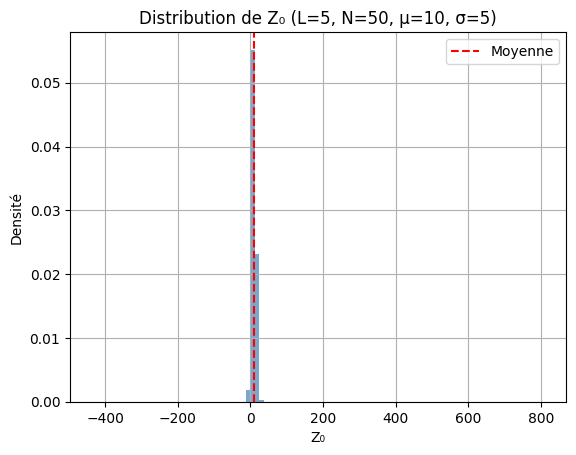

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de base
mu = 10           # moyenne des X_i
sigma = 5         # écart-type des X_i
L = 5            # nombre de composantes
N = 50          # somme cible
n_trials = 1000000 # nombre de répétitions pour estimer la variance

# Simulation des X_i ~ N(mu, sigma^2)
X = np.random.normal(loc=mu, scale=sigma, size=(n_trials, L))

# Calcul des Z_i = N * X_i / sum(X)
S = X.sum(axis=1, keepdims=True)    # somme de chaque ligne
Z = N * X / S                       # normalisation

# Empirical variance of Z_0 (toutes sont symétriques ici)
Z0 = Z[:, 0]
empirical_var = np.var(Z0)
# Théorie : Var(Z_i) ≈ (N^2 * σ^2 / (L^2 * μ^2)) * (1 + 1/L)
theoretical_var = (N**2 * sigma**2 / (L**2 * mu**2)) * (1 + 1 / L)

# Affichage des résultats
print(f"Empirical Var(Z₀)   = {empirical_var:.4f}")
print(f"Theoretical Var(Z₀) = {theoretical_var:.4f}")

# Histogramme
plt.hist(Z0, bins=100, density=True, alpha=0.7, color='steelblue')
plt.axvline(Z0.mean(), color='red', linestyle='--', label='Moyenne')
plt.title(f"Distribution de Z₀ (L={L}, N={N}, μ={mu}, σ={sigma})")
plt.xlabel("Z₀")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
DF_POLARS.group_by("profession").agg(
    pl.col("note_satisfaction").sum().alias("somme_satisfaction")
)

profession,somme_satisfaction
str,i64
"""ingénieur""",3376
"""médecin""",3061
"""avocat""",3266


In [1]:
import opendp.prelude as dp
import numpy as np
import polars as pl

dp.enable_features('contrib')

np.random.seed(42)

N = 1000
regions_fr = [
    "Île-de-France", "Auvergne-Rhône-Alpes", "Nouvelle-Aquitaine", "Occitanie",
    "Provence-Alpes-Côte d'Azur", "Grand Est", "Hauts-de-France", "Bretagne",
    "Normandie", "Centre-Val de Loire", "Pays de la Loire", "Bourgogne-Franche-Comté",
    "Corse"
]

DF_POLARS = pl.DataFrame({
    "sexe": np.random.choice(["H", "F"], size=N),
    "region": np.random.choice(regions_fr, size=N),
    "revenu_annuel": np.random.randint(10000, 80000, size=N),
    "profession": np.random.choice(["ingénieur", "médecin", "avocat"], size=N),
    "note_satisfaction": np.random.randint(0, 20, size=N),
    "heures_travaillees": np.random.randint(20, 60, size=N),
    "secteur d'activité": np.random.choice(["public", "privé", "associatif"], size=N)
})

# Clés valides pour les filtres
KEY_VALUES = {
    "sexe": ["H", "F"],
    "region": regions_fr,
    "profession": ["ingénieur", "médecin", "avocat"],
    "secteur d'activité": ["public", "privé", "associatif"]
}

# Contexte DP, construit une seule fois
CONTEXT_PARAM = {
    "data": DF_POLARS.lazy(),
    "privacy_unit": dp.unit_of(contributions=1),
    "margins": [
        dp.polars.Margin(max_partition_length=1000),
        dp.polars.Margin(
            by=["secteur d'activité", "region", "sexe", "profession"],
            public_info="keys",
            max_partition_length=1000
        ),
    ],
}


context = dp.Context.compositor(
            **CONTEXT_PARAM,
            privacy_loss=dp.loss_of(rho=0.02),
            split_evenly_over=1
        )

query = (
    context.query()
    #.filter(pl.col.sexe != "A")
    # release both the sum and length in one query
    .group_by(pl.col("profession"))
    .agg(
        pl.col.note_satisfaction
        .cast(int)
        .fill_null(35)
        .dp.sum(bounds=(0, 20))
    )
    .join(pl.DataFrame({"profession":["ingénieur", "médecin", "avocat", "test"]}).lazy(), on="profession", how="right")
)

print(query.summarize())

df = query.release().collect()
print(df)
valeur_test = df.filter(pl.col("profession") == "test")["note_satisfaction"][0]
print(valeur_test)

shape: (1, 4)
┌───────────────────┬───────────┬──────────────────┬───────┐
│ column            ┆ aggregate ┆ distribution     ┆ scale │
│ ---               ┆ ---       ┆ ---              ┆ ---   │
│ str               ┆ str       ┆ str              ┆ f64   │
╞═══════════════════╪═══════════╪══════════════════╪═══════╡
│ note_satisfaction ┆ Sum       ┆ Integer Gaussian ┆ 100.0 │
└───────────────────┴───────────┴──────────────────┴───────┘
shape: (4, 2)
┌───────────────────┬────────────┐
│ note_satisfaction ┆ profession │
│ ---               ┆ ---        │
│ i64               ┆ str        │
╞═══════════════════╪════════════╡
│ 3399              ┆ ingénieur  │
│ 3473              ┆ avocat     │
│ 3063              ┆ médecin    │
│ 119               ┆ test       │
└───────────────────┴────────────┘
119


In [113]:
np.random.seed(42)

list_valeur = []

for i in range(500):
    context = dp.Context.compositor(
            **CONTEXT_PARAM,
            privacy_loss=dp.loss_of(rho=0.02),
            split_evenly_over=1
        )

    query = (
        context.query()
        #.filter(pl.col.sexe != "A")
        # release both the sum and length in one query
        .group_by(pl.col("profession"))
        .agg(
            pl.col.note_satisfaction
            .cast(int)
            .fill_null(35)
            .dp.sum(bounds=(0, 20))
        )
        .join(pl.DataFrame({"profession":["ingénieur", "médecin", "avocat", "test"]}).lazy(), on="profession", how="right")
    )

    df = query.release().collect()
    valeur_test = df.filter(pl.col("profession") == "test")["note_satisfaction"][0]
    
    list_valeur.append(valeur_test)

print(list_valeur)

[64, 149, -154, -1, 69, 101, 121, -96, 38, 169, -81, -22, -116, 95, -45, -42, -27, 116, 46, -93, 120, 123, -48, -86, 9, 48, -32, -40, 28, -67, -29, -85, 253, -36, 99, 81, -48, 53, -5, -61, 99, 33, -163, 48, -29, -2, 140, -180, -63, -131, -13, -79, 5, -115, 178, 90, -13, -152, 14, 124, -114, 34, 77, 159, 39, -34, -186, 5, 69, -42, 29, -8, 91, -216, -145, -68, -30, 31, -100, -77, 78, -53, -127, -43, 21, 62, -60, 120, 121, 26, -9, -78, -84, 43, -185, -88, -18, 18, -102, 71, -150, -129, 79, 174, -90, 84, 164, 36, 99, -27, -8, 116, 73, 98, -60, 54, -89, 64, 107, 20, -108, -75, 13, -108, -32, -44, 56, 101, 11, 29, -54, -97, -43, -9, -192, -195, -18, -23, 94, -74, -225, 2, -65, -27, 9, -4, 151, 17, -45, 48, 120, -63, -89, 5, 49, -105, -164, 16, 7, 40, -74, -93, -100, 11, 53, 103, 49, -46, -11, -7, 82, -61, 174, 79, -50, 57, -135, 45, 43, 60, 104, 53, -77, -56, 1, -204, 93, -60, 29, 115, 51, 45, -56, -118, -91, -84, -35, 72, -202, 85, -225, 143, -74, 165, -87, 1, 73, 75, 71, -126, -144, 161, 2

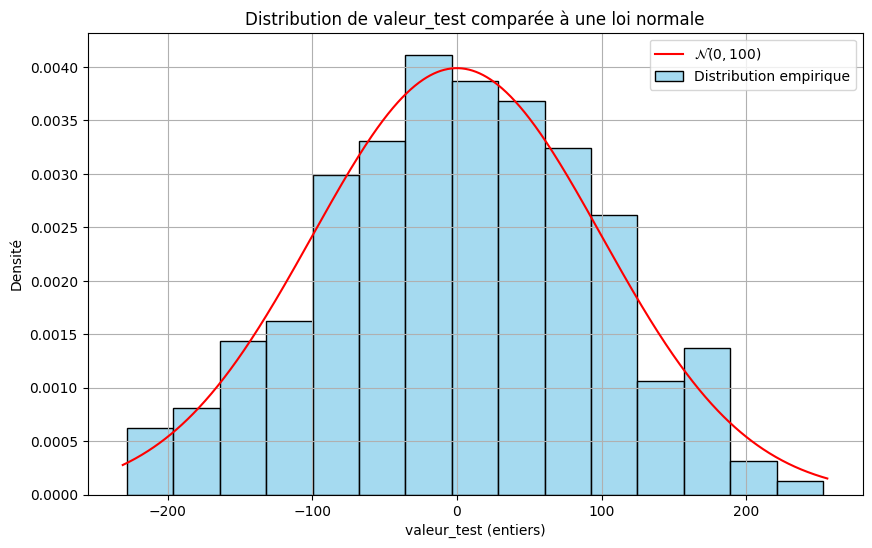

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Exemple de données simulées

# Paramètres pour la loi normale de comparaison
mu = 0
sigma = 100

# Bins entiers couvrant toutes les valeurs observées
min_val = min(list_valeur)
max_val = max(list_valeur)

# Abscisse pour la courbe de densité théorique
x = np.linspace(min_val - 3, max_val + 3, 1000)
densite_normale = norm.pdf(x, loc=mu, scale=sigma)

# Affichage
plt.figure(figsize=(10, 6))
sns.histplot(list_valeur, bins=15, stat="density", color="skyblue", label="Distribution empirique")

# Ajout de la densité normale théorique
plt.plot(x, densite_normale, color="red", label=r"$\mathcal{N}(0, 100)$")

plt.title("Distribution de valeur_test comparée à une loi normale")
plt.xlabel("valeur_test (entiers)")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


In [128]:
from scipy.stats import norm

# Loi normale centrée réduite (mu = 0, sigma = 1)
proba = norm.cdf(200 - 20/0.85, loc=0, scale=100)
print(1-proba)

0.038806604728851224


In [41]:
import opendp.prelude as dp
import numpy as np
import polars as pl

dp.enable_features('contrib')

np.random.seed(42)

N = 2

DF_POLARS = pl.DataFrame({
    "sexe": np.random.choice(["H", "F"], size=N),
    "revenu_annuel": np.random.randint(10000, 80000, size=N)
})

# Clés valides pour les filtres
KEY_VALUES = {
    "sexe": ["H", "F"]
}

# Contexte DP, construit une seule fois
CONTEXT_PARAM = {
    "data": DF_POLARS.lazy(),
    "privacy_unit": dp.unit_of(contributions=1),
    "margins": [
        dp.polars.Margin(max_partition_length=1000),
    ],
}


context = dp.Context.compositor(
            **CONTEXT_PARAM,
            privacy_loss=dp.loss_of(rho=0.02),
            split_evenly_over=1
        )

query = (
    context.query()
    .with_columns(pl.lit(1).alias("nouvelle_colonne"))
    .select(
        pl.col("nouvelle_colonne")
        .fill_null(1)
        .dp.sum((1,1))
    )
)

print(query.summarize())

df = query.release().collect()
print(df)

shape: (1, 4)
┌──────────────────┬───────────┬──────────────────┬───────┐
│ column           ┆ aggregate ┆ distribution     ┆ scale │
│ ---              ┆ ---       ┆ ---              ┆ ---   │
│ str              ┆ str       ┆ str              ┆ f64   │
╞══════════════════╪═══════════╪══════════════════╪═══════╡
│ nouvelle_colonne ┆ Sum       ┆ Integer Gaussian ┆ 5.0   │
└──────────────────┴───────────┴──────────────────┴───────┘
shape: (1, 1)
┌──────────────────┐
│ nouvelle_colonne │
│ ---              │
│ i32              │
╞══════════════════╡
│ -3               │
└──────────────────┘


In [33]:
np.random.seed(42)

list_valeur = []

for i in range(10):
    context = dp.Context.compositor(
            **CONTEXT_PARAM,
            privacy_loss=dp.loss_of(rho=0.02),
            split_evenly_over=1
        )

    query = (
        context.query()
        .select(
            pl.col("revenu_annuel")
            .fill_null(1)
            .dp.sum((1,1))
        )
    )

    df = query.release().collect().item()
    
    list_valeur.append(df)

print(list_valeur)

[10, 12, 9, 2, 5, 5, 8, 2, -3, 3]
